In [1]:
import numpy as np
import matplotlib.pyplot as plt

from RigidWall_InertialLangevin3D_cython import RigidWallInertialLangevin3D

from mpl_toolkits import mplot3d
from scipy.signal import correlate

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 140

# Langevin 3D Inertial close rigid wall

Voici la partie du code qui cacule la position $x_i$ tel que :

\begin{equation}
    x_i = x_{i-1} + ( - \Delta m g + R_{elec} + F_{correction} ) \frac{\Delta t}{\gamma (z)} + a(\gamma (z)) * dB_t * \Delta t
\end{equation}

<font color='blue'> 
    J'avais des problème au niveau de la PDF, en tatonant pour voir ce qui ne va pas, j'ai remarqué que c'est le poids qui n'allait pas. </font>
<font color='blue'>     
    Comme ci-dessous, j'ai divisé le poids $\Delta m g$ par deux et dans ce cas, la PDF est quasi parfaite (voir cellule 7). </font>
<font color='blue'>     
    Par contre la MSD (cellule 11) ne va plus trop entre la théorique (calculé avec le coef de diffusion moyen) et la MSD numérique. Le facteur 1/2 décale les MSD théoriques des MSD numérique. C'est étrange ...</font>


if axis == "z":

    gamma = self._gamma_z(zi_1) # Pade formula
    weight = self.delta_m * self.g * self.dt / (gamma) / 2
    elec = (
            (4 * self.kb * self.T)
            / (self.lD)
            * np.exp(-zi_1 / self.lD)
            * self.dt
            / gamma
           )
    correction = (
                  self.kb
                  * self.T
                  * (42 * self.R * zi_1 ** 2 + 24 * self.R ** 2 * zi_1 + 4 *                        self.R ** 3)
                  / ((6 * zi_1 ** 2 + 9 * self.R * zi_1 + 2 * self.R ** 2)**2 )
                  * self.dt
                  / gamma
                 )


else:

    gamma = self._gamma_xy(zi_1) # Libchaber formula
    elec = 0
    weight = 0
    correction = 0

xi = xi_1 - weight + elec + correction + self._a(gamma) * rng * self.dt

if axis == "z":

    if xi <= 0:
    xi = -xi

In [2]:
langevin3D = RigidWallInertialLangevin3D(dt=1/600, Nt=1000000, R=1.5e-6, rho=1050, x0=(0., 0., 1.5e-6))
langevin3D.trajectory()

## 1. Trajectory

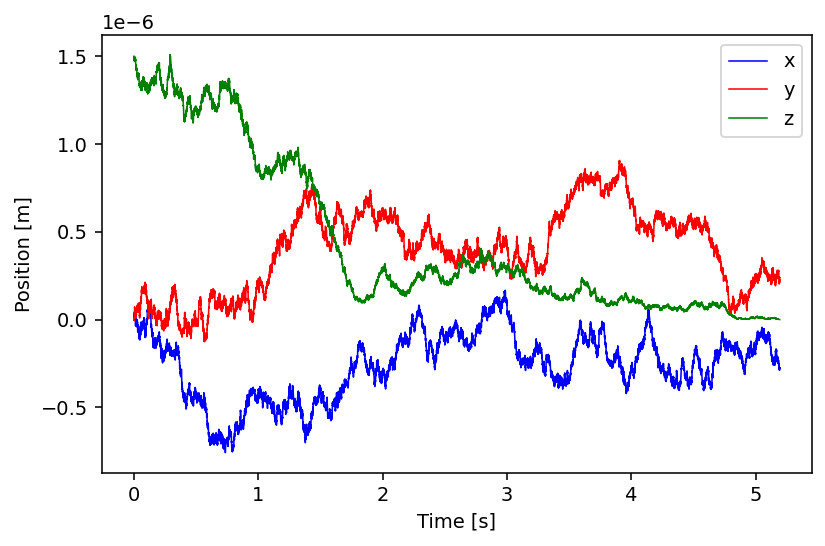

In [3]:
langevin3D.plotTrajectory()

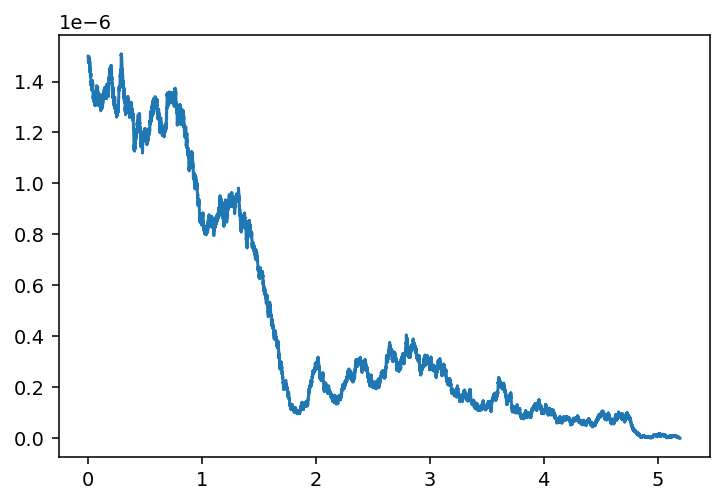

In [4]:
plt.plot(langevin3D.t[0:langevin3D.Nt], langevin3D.z[0:langevin3D.Nt])
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

## 2. Mean square displacement

In [5]:
MSDx = langevin3D.MSD1D("x", output=True)
MSDy = langevin3D.MSD1D("y", output=True)
MSDz = langevin3D.MSD1D("z", output=True)

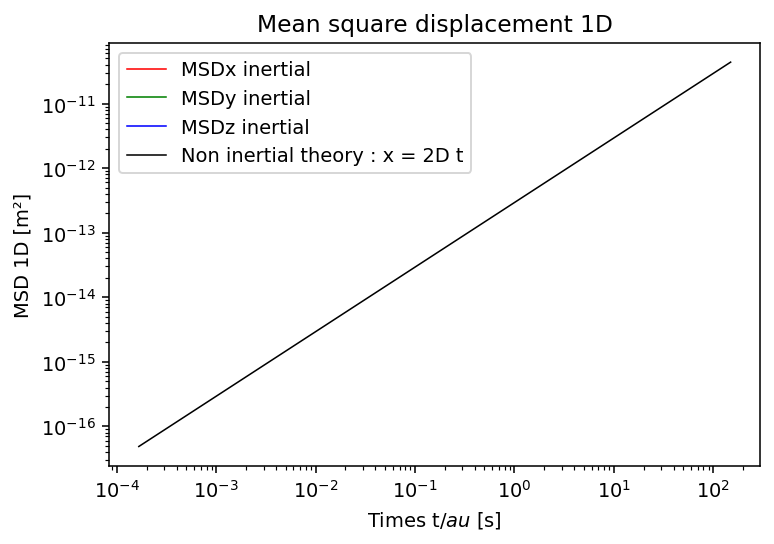

In [6]:
fig1 = plt.figure()
plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD],
    MSDx,
    color="red",
    linewidth=0.8,
    label="MSDx inertial",
)
plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD] ,
    MSDy,
    color="green",
    linewidth=0.8,
    label="MSDy inertial",
)
plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD] ,
    MSDz,
    color="blue",
    linewidth=0.8,
    label="MSDz inertial",
)
plt.plot(
    langevin3D.t[langevin3D.list_dt_MSD] ,
    (2 * langevin3D.kb * langevin3D.T / langevin3D.gamma)
    * langevin3D.t[langevin3D.list_dt_MSD],
    color="black",
    linewidth=0.8,
    label="Non inertial theory : x = 2D t",
)
plt.xlabel("Times t/$ \tau $ [s]")
plt.ylabel("MSD 1D [m²]")
plt.title("Mean square displacement 1D")
plt.legend()
plt.show()

## 3. Probability density function of z

In [7]:
axis = "z"
bins = 100
hist, bin_edges = np.histogram(langevin3D.z, bins=bins, density=True)
binsPosition = (bin_edges[:-1] + bin_edges[1:]) / 2
pdf = hist * 1/np.trapz(hist,binsPosition)

pdf_theo = np.exp( -(4) * np.exp(- binsPosition/langevin3D.lD) - binsPosition/langevin3D.lB)
pdf_theo = pdf_theo * 1/np.trapz(pdf_theo,binsPosition) # normalised

plt.semilogy(binsPosition,pdf, "*", label="numerical with bins = " + str(bins))
plt.plot(binsPosition, pdf_theo, "-", label="theory")

plt.title("Probability density function of " + axis)
plt.xlabel(axis + " $[m]$")
plt.ylabel("PDF $[m^{-1}]$")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
plt.legend()
plt.show()

ValueError: autodetected range of [nan, nan] is not finite

In [ ]:
plt.semilogy(binsPosition, pdf - pdf_theo, "*", label="theo - num : with bins = " + str(bins))

plt.title("Probability density function of " + axis)
plt.xlabel(axis + " $[m]$")
plt.ylabel("PDF $[m^{-1}]$")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
plt.legend()
plt.axis([None, None, 1e0, 1e6])
plt.show()

## 4. Mesure average of diffusion coeficient

In [ ]:
# ----- On Z --------- !
# Diffusion coef
Dz = (langevin3D.kb*langevin3D.T) / (langevin3D._gamma_z(binsPosition))
# function to integrate
f_theo = Dz * pdf_theo
# Theoritical diffusion coef
mean_D_theo = np.trapz(f_theo,binsPosition)
print("<Dz>_theo/D_0 = {:.2f}".format(mean_D_theo/(langevin3D.kb * langevin3D.T / langevin3D.gamma)))

# -------- On X ----------- !
Dx = (langevin3D.kb*langevin3D.T) / (langevin3D._gamma_xy(binsPosition))
fx_theo = Dx * pdf_theo
mean_Dx_theo = np.trapz(fx_theo,binsPosition)
print("<Dx>_theo/D_0 = {:.10f}".format(mean_Dx_theo/(langevin3D.kb * langevin3D.T / langevin3D.gamma)))

In [ ]:
Do = langevin3D.kb * langevin3D.T / langevin3D.gamma

In [ ]:
fig1 = plt.figure()
plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD],
    MSDx,
    color="red",
    linewidth=1.2,
    label="MSDx inertial",
)
plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD] ,
    MSDy,
    color="orange",
    linewidth=1.2,
    label="MSDy inertial",
)
plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD] ,
    MSDz,
    color="blue",
    linewidth=1.2,
    label="MSDz inertial",
)
plt.plot(
    langevin3D.t[langevin3D.list_dt_MSD] ,
    2*mean_Dx_theo
    * langevin3D.t[langevin3D.list_dt_MSD],
    color="magenta",
    linewidth=1.2,
    label="MSDx theo : x = 2<D(x)> t",
)
plt.plot(
    langevin3D.t[langevin3D.list_dt_MSD] ,
    2*mean_D_theo
    * langevin3D.t[langevin3D.list_dt_MSD],
    color="cyan",
    linewidth=1.2,
    label="MSDz theo : z = 2<D(z)> t",
)
plt.xlabel("Times t/$ \tau $ [s]")
plt.ylabel("MSD 1D [m²]")
plt.title("Mean square displacement 1D")
plt.legend()
plt.show()

In [ ]:
mean_Dx_theo/(langevin3D.kb * langevin3D.T / langevin3D.gamma)

## 5. Les tests

In [ ]:
zi_1 = langevin3D.z
gamma_z = langevin3D._gamma_z(zi_1)
gamma0 = langevin3D.gamma

In [ ]:
plt.loglog(zi_1, gamma0/gamma_z, "*", label="$\\gamma_z^{used}$ from Pade formula")
plt.plot(zi_1, 8/9 * zi_1/langevin3D.R, label="$\\gamma_z^{theo}$ from lubrification approx")
plt.xlabel("z [m]")
plt.ylabel("$\\gamma_0 / \\gamma_z$ ")
plt.legend(loc="upper left")

In [ ]:
gamma_xy = langevin3D._gamma_xy(zi_1)

In [ ]:
plt.loglog(zi_1, gamma0/gamma_xy, "*", label="$\\gamma_x^{used}$ from Libchaber")
plt.xlabel("z [m]")
plt.ylabel("$\\gamma_0/ \\gamma_x$")
plt.legend(loc="upper left")

In [ ]:
weight = (langevin3D.delta_m) * langevin3D.g * np.ones(langevin3D.Nt)
elec = (
                (4 * langevin3D.kb * langevin3D.T)
                / (langevin3D.lD)
                * np.exp(-zi_1 / langevin3D.lD)
            )
correction = (
                langevin3D.kb
                * langevin3D.T
                * (42 * langevin3D.R * zi_1 ** 2 + 24 * langevin3D.R ** 2 * zi_1 + 4 * langevin3D.R ** 3)
                / ((6 * zi_1 ** 2 + 9 * langevin3D.R * zi_1 + 2 * langevin3D.R ** 2) ** 2)
            )

In [ ]:
plt.plot(zi_1, weight, ".", label="Weight : $\\Delta m g $")
plt.xlabel("z [m]")
plt.ylabel("$Forces$")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
#plt.axis([-1e-7, 1e-5, None, None])
plt.legend(loc="upper right")

In [ ]:
plt.plot(zi_1, elec, ".", label="Repultion : $R_{elec} $")
plt.xlabel("z [m]")
plt.ylabel("$Forces$")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
#plt.axis([-1e-7, 1e-5, None, None])
plt.legend(loc="center right")

In [ ]:
plt.plot(zi_1, correction, ".", label="Correction : $F_{correc}$ ")
plt.xlabel("z [m]")
plt.ylabel("$Forces$")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
#plt.axis([-1e-7, 1e-5, None, None])
plt.legend(loc="center right")

In [ ]:
langevin3D.lB